In [101]:
youtube_ml = pd.read_pickle("youtube_features.pkl")

# Predicting Youtube View Counts

In this project our goal was to analyze what features of youtube videos contribute most to its view count. It is interesting to see, given a new video, how many views we could predict that video to have. Knowing certain features influence view count could help a youtube influencer better promote their video.

## Data Collection

We wanted to gather a large unbaised random sample of about 100,000 youtube videos with a good view count distribution. This task ended up being more challenging than we anticipated. 


### Attempt 1
Our first attempt was to generate a random video id. This is a 11 character string of numbers and letters. However such an id often does not correspond to an existing video. Since we wanted to do text analysis, we filtered to only have English videos which further limited our results. So in querying the Youtube API we quickly hit our daily quota (of 1 million units) without getting even a few 100 videos. 

### Attempt 2
Since generating an entire video id rarely hit a valid video we instead tried only generating a partial id and searching for videos containing that id. Since the API doesn't support search by partial id we instead searched with that partial id as the keyword. We then searched through the resulting videos (50 max) to find if one of them had an id containing partial id and was in English. The issue was that since we only could use one video out of the 50 results and we had to make a second query to get all the corresponding video details, this once again quickly maxed our query limit. 

### Attempt 3
This time we randomly chose a word from the English dictionary and used that as the query term. The problem with this was that since Youtube sorts results by relevance (which is usually view count), this biased our results to have really high view counts. The only ways to change this sort was by date published or rating which would still lead to in biased results. We considered seaching with more than one English word to make it less common to hit a match. This still did not completely resolve the aforementioned issues though.

### Final Attempt
Ultimately we found a tensorflow dataset (https://research.google.com/youtube8m/download.html) of 8 million random video ids. From this we randomly selected 10% of the ids and made a second query to the Youtube API to obtain the video details. This involved filtering if the result was not English or no longer corresponded to an actual video (i.e. was removed since publication of dataset etc). Most of these ids corresponded to existing English videos so we could complete the scraping process within the limits of the API quota. We ended with approximatley 90,000 videos.  

In [ ]:
from googleapiclient.discovery import build
from googletrans import Translator
import random
import string
import json
import csv
import pandas as pd

global videoIdLen
videoIdLen = 3
numVideos = 3

#from youtube API documentation
def remove_empty_kwargs(**kwargs):
  good_kwargs = {}
  if kwargs is not None:
    for key, value in kwargs.items():
      if value:
        good_kwargs[key] = value
  return good_kwargs

#from youtube API documentation
def videos_list_by_id(client, **kwargs):
  kwargs = remove_empty_kwargs(**kwargs)

  response = client.videos().list(
    **kwargs
  ).execute()
  return response

#from youtube API documentation
def get_authenticated_service():
    api_key = open('api_key.txt', 'r').read()
    return build('youtube', 'v3', developerKey = api_key)


def checkField(vid, fieldType, first, second):
    if (second in vid[first]):
        return vid[first][second]
    else:
        if (fieldType == "str"):
            return ""
        elif (fieldType == "int"):
            return 0
        else:
            return []

client = get_authenticated_service()
f = open("rand_videos.txt","a")
translator = Translator()
csv_file = open('video_data.csv', 'w', newline = "", encoding='utf-8')
fieldnames = ['id', 'title', 'description', 'channelTitle', 'commentCount', 'viewCount', 'favoriteCount', 'dislikeCount', 'likeCount', 'tags', 'topics']
writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
writer.writeheader()

f_ids = open("videoIdsAndLabels.txt", "r")
vocab = pd.read_csv("vocabulary.csv")

for line in f_ids:
    parts = line.split()
    vidId = parts[0]
    labels = parts[1:]
    
    video_response = videos_list_by_id(client,
        id = vidId,
        part = 'snippet, statistics')
    newVideo = {}
    try:  
        if (len(video_response['items']) == 0):
            continue
        vid = video_response['items'][0]
        title = vid['snippet']['title']
        lang = translator.detect(title)
        if lang.lang == 'en' and lang.confidence > 0.50:
            topics = []
            for label in labels:
                label_fix = label.replace('[','').replace(']','').replace(',','')
                topic = vocab['Name'][int(label_fix)]
                topics.append(topic)
            newVideo['topics'] = topics
            newVideo['id'] = vidId
            newVideo['title'] = title 
            newVideo['description'] = checkField(vid, "str", "snippet", "description")
            newVideo['channelTitle'] = checkField(vid, "str", "snippet", "channelTitle")
            newVideo['commentCount'] = checkField(vid, "int", "statistics", "commentCount")
            newVideo['viewCount'] = checkField(vid, "int", "statistics", "viewCount")
            newVideo['favoriteCount'] = checkField(vid, "int", "statistics", "favoriteCount")
            newVideo['dislikeCount'] = checkField(vid, "int", "statistics", "dislikeCount")
            newVideo['likeCount'] = checkField(vid, "int", "statistics", "likeCount")
            newVideo['tags'] = checkField(vid, "list", "snippet", "tags")
            writer.writerow(newVideo)
            f.write(json.dumps(vid))
            f.write('\n')
    except Exception as e:
        pass

f.close()
f_ids.close()
csv_file.close()

## Data 

The data we collected had the following pieces of information:
    1. topics (list of strings)
    2. id (string)
    3. title (string) 
    4. description (string)
    4. channel title (string)
    5. comment count (int)
    6. view count (int)
    7. favorite count (int)
    8. dislike count (int)
    9. like count (int)
    10. tags (list of strings)
    
Out of these, we removed id because it is just an identifier for videos. We also removed description because it is not a required field, which made it difficult to use as a feature. We don't expect channel title to influence view count because across a random distribution of videos it is unlikely for multiple videos to share the same channel title. After some investigation, we saw that favorite count was 0 for all videos, and so we excluded that. Lastly, we found that tags are very specific to videos so not helpful overall features.

## Feature Selection

Next we wanted to see which features were correlated with view count. To do this we used plotnine which implements gglot in Python.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from plotnine import *
import pandas as pd 
import numpy as np

youtube_data = pd.read_csv("video_data_final.csv", encoding = "ISO-8859-1")

We started by visualizing the distribution of view counts. This boxplot shows the distribution is heavily right skewed. 

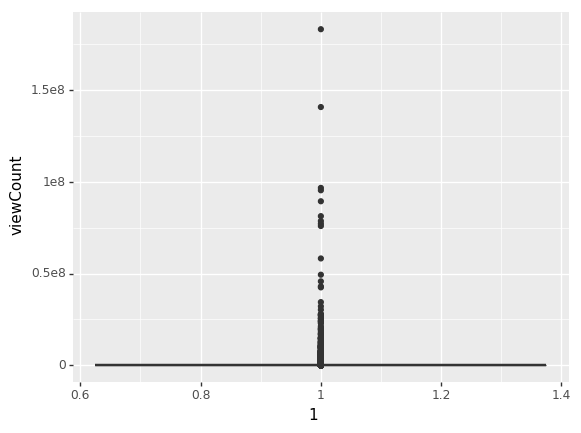

<ggplot: (291058317)>

In [91]:
ggplot(youtube_data, aes(y = "viewCount", x = '1')) + \
    geom_boxplot(alpha = 0.5)

To adjust for the skewedness we tried a log transform.

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_boxplot : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


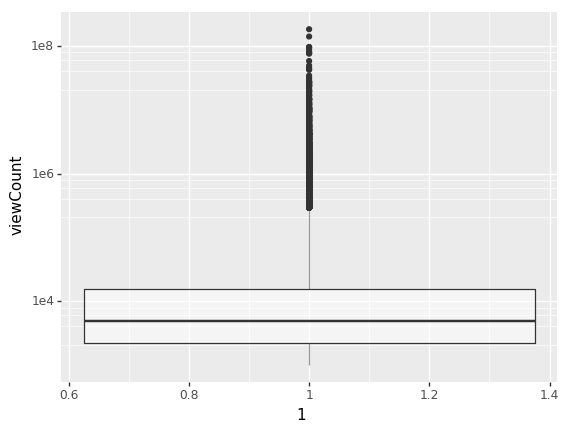

<ggplot: (-9223372036520801020)>

In [89]:
ggplot(youtube_data, aes(y = "viewCount", x = '1')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10()

Although this looked better, it shows a normally distributed group of points followed by a group of very high outliers. 

In [5]:
youtube_data["viewCount"].describe()

count    9.219100e+04
mean     6.946795e+04
std      1.248694e+06
min      0.000000e+00
25%      2.240000e+03
50%      4.942000e+03
75%      1.573100e+04
max      1.832004e+08
Name: viewCount, dtype: float64

Consequenly we decided to split our data into 2 groups: outlier vs non-outlier. We used the statistics above to determine to split at 1.5*(interquartile range) + 75th percentile. 

In [93]:
outlier_start = 1.5*(15731.00 - 2240.000) + 15731.00 #1.5(IQR) + 75th quartile
youtube_data['outlier'] = np.where(youtube_data['viewCount']>=outlier_start, 'outlier', 'notOutlier')

In the following graph we see now the nonoutlier data looks relatively normally distributed. The outlier data is still skewed right.

/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/scales/scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)
/Users/rupalnahar/anaconda3/lib/python3.6/site-packages/plotnine/layer.py:363: UserWarning: stat_boxplot : Removed 17 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


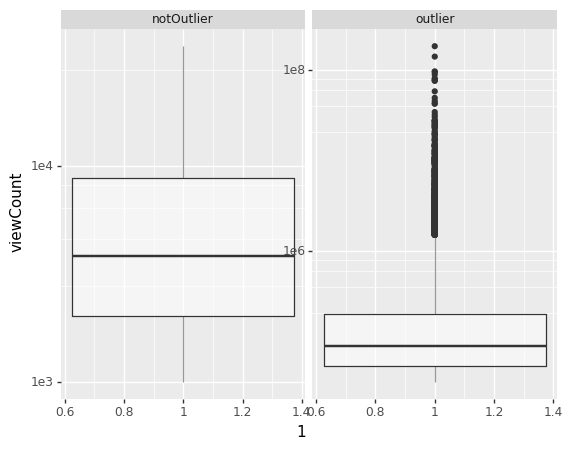

<ggplot: (-9223372036575018622)>

In [94]:
ggplot(youtube_data, aes(y = "viewCount", x = '1')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

We now go into visualizing the features, starting with like, dislike and comment counts. For all 3 of these graphs it was better to do a log transform on the x axis as well. 

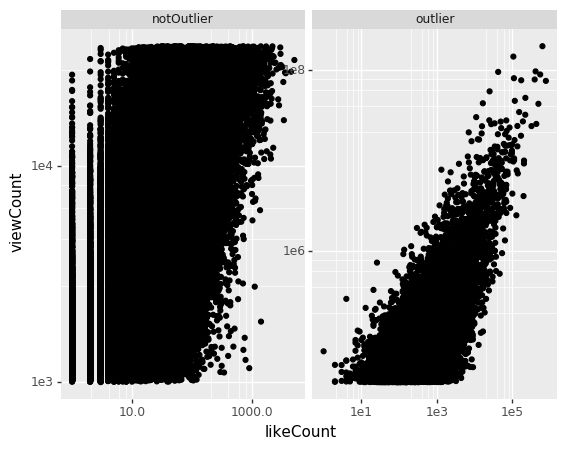

<ggplot: (420003062)>

In [106]:
ggplot(youtube_data, aes(x = "likeCount", y = "viewCount",)) + \
    geom_point() + \
    scale_x_log10() + \
    scale_y_log10() + facet_wrap("outlier", scales="free")

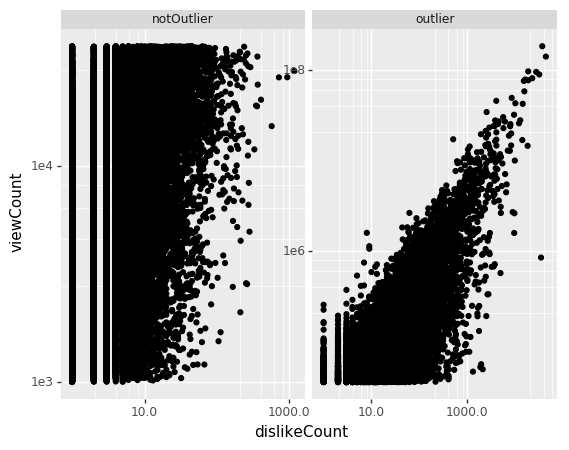

<ggplot: (404122828)>

In [105]:
ggplot(youtube_data, aes(x = "dislikeCount", y = "viewCount")) + \
    geom_point() + \
    scale_x_log10() + \
    scale_y_log10()  + facet_wrap("outlier", scales="free")

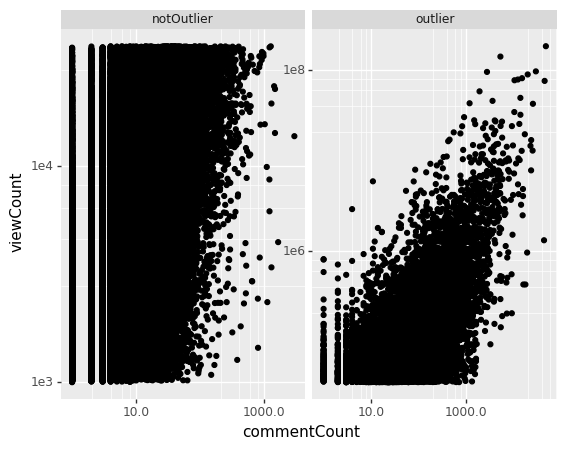

<ggplot: (398109125)>

In [104]:
ggplot(youtube_data, aes(x = "commentCount", y = "viewCount")) + \
    geom_point() + \
    scale_x_log10() + \
    scale_y_log10()  + facet_wrap("outlier", scales="free")

We note there is a slight positive corrleation in the non-outliers and a greater positive correlation in the outliers.

### Text Analysis on Title Feature

We explored several different ways of using the title. We started with a basic approach of just looking at the length of the title.

#### Method 0: Length of Title

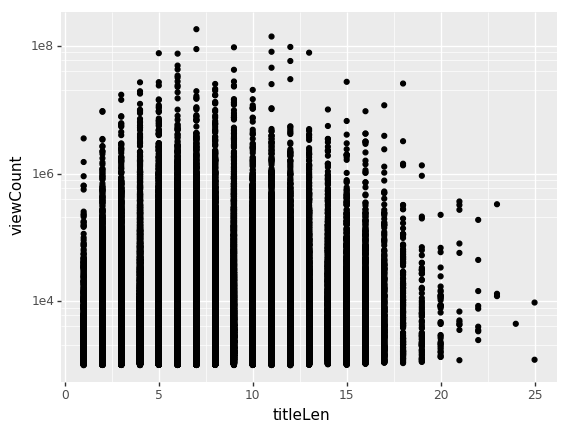

<ggplot: (-9223372036307068812)>

In [159]:
youtube_data['titleLen'] = youtube_data['titleWords'].apply(lambda x: len(x))

ggplot(youtube_data, aes(x = 'titleLen', y = 'viewCount')) + \
scale_y_log10() + geom_point() 

#### Method 1: Tfidf

Next we tried to convert the title into tfidf vectors.

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer

def toTfidf(text):
    vectorizer = TfidfVectorizer(stop_words = "english")
    # tokenize and build vocab
    return (vectorizer.fit_transform(text))

allTitles = list(youtube_data['title'])
tfidf = toTfidf(allTitles)

def getFeatures(tfidf, tfidf_type):
    result = []
    for i in range(tfidf.shape[0]):
        vector = tfidf[i]
        if (tfidf_type == 'min'):
            result.append(np.min(vector))
        elif (tfidf_type == 'max'):
            result.append(np.max(vector))
        else:
            #average
            result.append(np.mean(vector))
    return pd.Series(result)

We considered 2 ways of doing tdifd: mean and min. The initial goal was to use the min method because tfidf assigns the more frequent words with lower tfidf scores. We expect the more frequent words to be the clickbait words which might influence the view count the most. However, since tfidf features is a sparse matrix the min was mostly 0. Thus we resorted to trying mean.  

In [ ]:
youtube_data['mean_title'] = getFeatures(tfidf, 'mean')

In [112]:
youtube_data['min_title'] = getFeatures(tfidf, 'min')
print(youtube_data['min_title'].unique())

[0.]


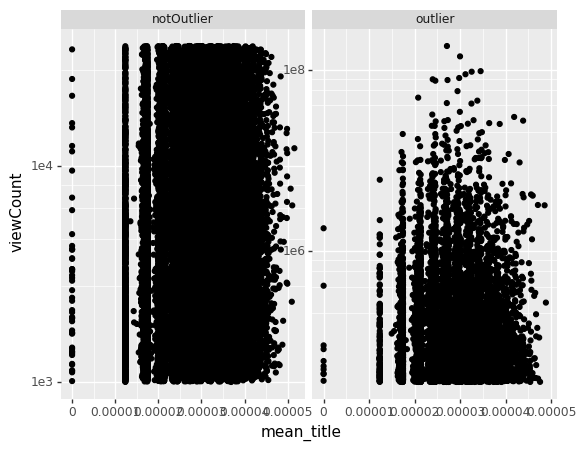

<ggplot: (-9223372036388116641)>

In [114]:
ggplot(youtube_data, aes(x = "mean_title", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

We do not see any correlation between mean title and view count. Thus we will not use this as a feature in our ML model. 

####  Method 2: Part of Speech Tagging

Next, we tagged each of the words in the title with its corresponding part of speech. We then converted this to a frequency vector for each part of speech tag. 

In [7]:
import nltk
import re
import string

def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    """ Normalizes case and handles punctuation
    Inputs:
        text: str: raw text
        lemmatizer: an instance of a class implementing the lemmatize() method
                    (the default argument is of type nltk.stem.wordnet.WordNetLemmatizer)
    Outputs:
        list(str): tokenized text
    """
    text = text.lower()
    text = re.sub('\'s', '', text)
    text = re.sub('\'', '', text)
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    out = text.translate(translator)
    arr = nltk.word_tokenize(out)
    ans = []
    for word in arr:
        try:
            w = lemmatizer.lemmatize(word)
            ans.append(w)
        except:
            continue
    return ans

youtube_data['titleWords'] = youtube_data['title'].apply(lambda x: process(x))
youtube_data['pos_tags'] = youtube_data['titleWords'].apply(lambda t: nltk.pos_tag(t))

In [160]:
from collections import Counter

youtube_data['pos_freq'] = youtube_data['pos_tags'].apply(lambda l: Counter([tag for (word, tag) in l]))

In [176]:
youtube_data['title_CC'] = youtube_data['pos_freq'].apply(lambda C: C['CC'])
youtube_data['title_CD'] = youtube_data['pos_freq'].apply(lambda C: C['CD'])
youtube_data['title_DT'] = youtube_data['pos_freq'].apply(lambda C: C['DT'])
youtube_data['title_EX'] = youtube_data['pos_freq'].apply(lambda C: C['EX'])
youtube_data['title_IN'] = youtube_data['pos_freq'].apply(lambda C: C['IN'])
youtube_data['title_JJ'] = youtube_data['pos_freq'].apply(lambda C: C['JJ'])
youtube_data['title_JJR'] = youtube_data['pos_freq'].apply(lambda C: C['JJR'])
youtube_data['title_JJS'] = youtube_data['pos_freq'].apply(lambda C: C['JJS'])
youtube_data['title_LS'] = youtube_data['pos_freq'].apply(lambda C: C['LS'])
youtube_data['title_MD'] = youtube_data['pos_freq'].apply(lambda C: C['MD'])
youtube_data['title_NN'] = youtube_data['pos_freq'].apply(lambda C: C['NN'])
youtube_data['title_NNP'] = youtube_data['pos_freq'].apply(lambda C: C['NNP'])
youtube_data['title_NNS'] = youtube_data['pos_freq'].apply(lambda C: C['NNS'])
youtube_data['title_NNPS'] = youtube_data['pos_freq'].apply(lambda C: C['NNPS'])
youtube_data['title_PDT'] = youtube_data['pos_freq'].apply(lambda C: C['PDT'])
youtube_data['title_POS'] = youtube_data['pos_freq'].apply(lambda C: C['POS'])
youtube_data['title_PRP'] = youtube_data['pos_freq'].apply(lambda C: C['PRP'])
youtube_data['title_PRP$'] = youtube_data['pos_freq'].apply(lambda C: C['PRP$'])
youtube_data['title_RB'] = youtube_data['pos_freq'].apply(lambda C: C['RB'])
youtube_data['title_RBR'] = youtube_data['pos_freq'].apply(lambda C: C['RBR'])
youtube_data['title_RBS'] = youtube_data['pos_freq'].apply(lambda C: C['RBS'])
youtube_data['title_RP'] = youtube_data['pos_freq'].apply(lambda C: C['RP'])
youtube_data['title_TO'] = youtube_data['pos_freq'].apply(lambda C: C['TO'])
youtube_data['title_UH'] = youtube_data['pos_freq'].apply(lambda C: C['UH'])
youtube_data['title_VB'] = youtube_data['pos_freq'].apply(lambda C: C['VB'])
youtube_data['title_VBD'] = youtube_data['pos_freq'].apply(lambda C: C['VBD'])
youtube_data['title_VBG'] = youtube_data['pos_freq'].apply(lambda C: C['VBG'])
youtube_data['title_VBN'] = youtube_data['pos_freq'].apply(lambda C: C['VBN'])
youtube_data['title_VBP'] = youtube_data['pos_freq'].apply(lambda C: C['VBP'])
youtube_data['title_VBZ'] = youtube_data['pos_freq'].apply(lambda C: C['VBZ'])
youtube_data['title_WDT'] = youtube_data['pos_freq'].apply(lambda C: C['WDT'])
youtube_data['title_WP'] = youtube_data['pos_freq'].apply(lambda C: C['WP'])
youtube_data['title_WRB'] = youtube_data['pos_freq'].apply(lambda C: C['WRB'])

We took out the tags that had max count of 0 since these would not give us any information. We also removed the tags which had no correlation with view count. The remaining tags were: adjective, cardinal digit, and preposition or subordinating conjunction. 

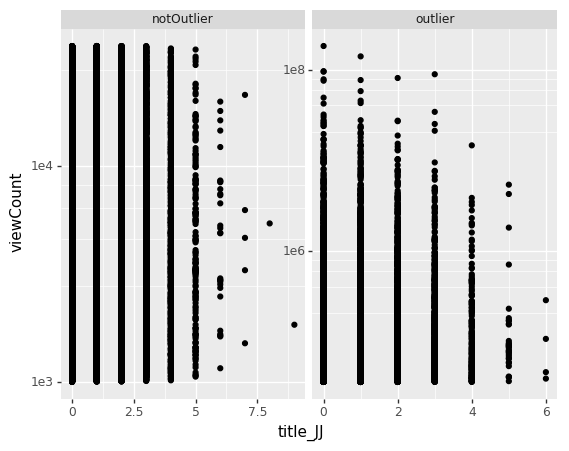

<ggplot: (415120630)>

In [169]:
#adjective
ggplot(youtube_data, aes(x = "title_JJ", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

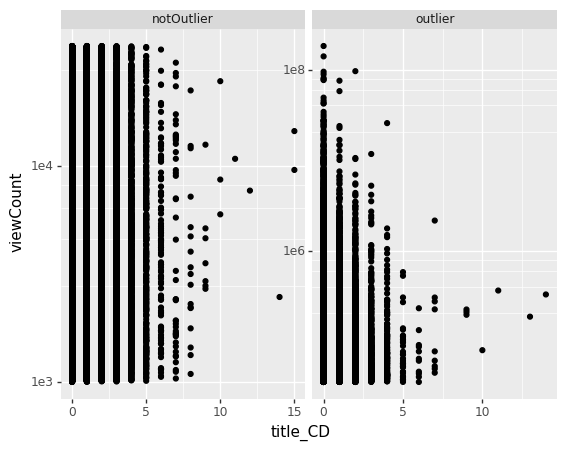

<ggplot: (-9223372036534732193)>

In [163]:
#Cardinal Digit
ggplot(youtube_data, aes(x = "title_CD", y = "viewCount")) + \
    geom_point()  + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

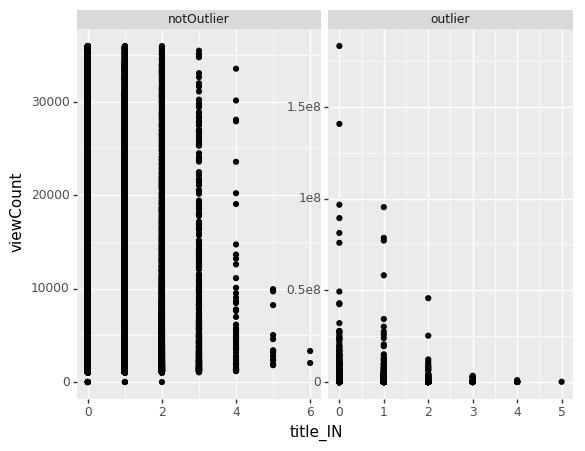

<ggplot: (-9223372036457518504)>

In [120]:
#Preposition or Subordinating Conjunction
ggplot(youtube_data, aes(x = "title_IN", y = "viewCount")) + \
    geom_point() + \
    facet_wrap("outlier", scales="free")

#### Method 3: Sentiment Analysis

Then, we performed sentiment analysis on the title, which gave us values for how positive, negative, or neutral the text was.

In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def getSentimentScore(text, sentimentType):
    #sentimentType: compound, neg, neu, pos
    return (analyzer.polarity_scores(text)[sentimentType])

C:\Users\Asra\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [5]:
youtube_data['titlePos'] = youtube_data['title'].apply(lambda text : getSentimentScore(text, 'pos'))
youtube_data['titleNeg'] = youtube_data['title'].apply(lambda text : getSentimentScore(text, 'neg'))
youtube_data['titleNeu'] = youtube_data['title'].apply(lambda text : getSentimentScore(text, 'neu'))
youtube_data['titleCompound'] = youtube_data['title'].apply(lambda text : getSentimentScore(text, 'compound'))

C:\Users\Asra\Anaconda3\lib\site-packages\plotnine\scales\scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


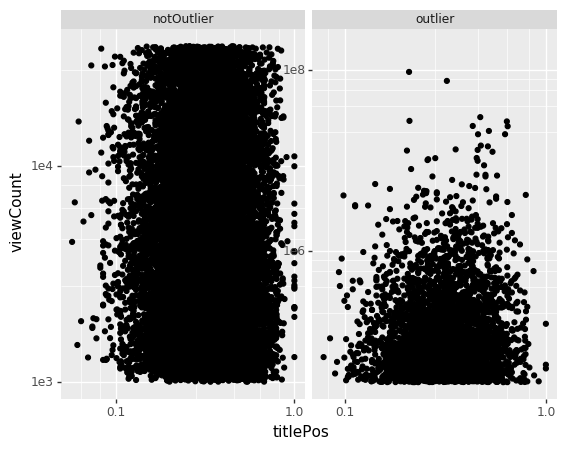

<ggplot: (97861192084)>

In [6]:
#Positive sentiment
ggplot(youtube_data, aes(x = "titlePos", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    scale_x_log10() + \
    facet_wrap("outlier", scales="free")

C:\Users\Asra\Anaconda3\lib\site-packages\plotnine\scales\scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


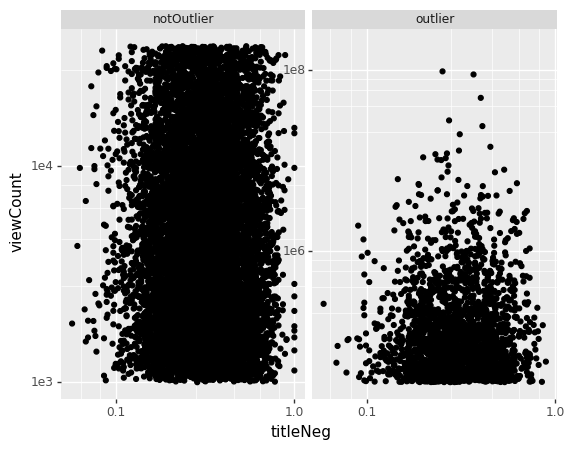

<ggplot: (-9223371938983894703)>

In [7]:
# Negative sentiment
ggplot(youtube_data, aes(x = "titleNeg", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    scale_x_log10() + \
    facet_wrap("outlier", scales="free")

C:\Users\Asra\Anaconda3\lib\site-packages\plotnine\scales\scale.py:516: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


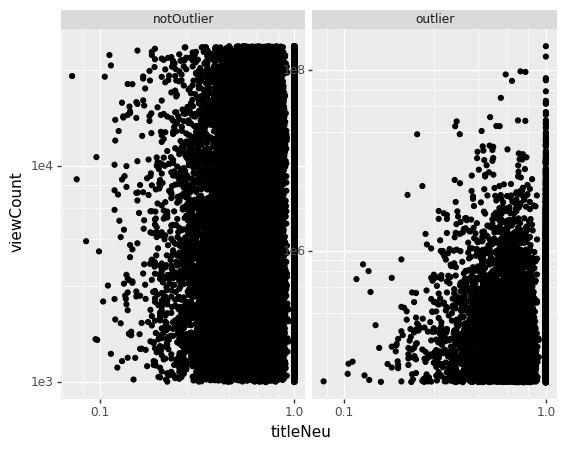

<ggplot: (-9223371938998731723)>

In [8]:
# Neutral sentiment
ggplot(youtube_data, aes(x = "titleNeu", y = "viewCount")) + \
    geom_point() + \
    scale_y_log10() + \
    scale_x_log10() + \
    facet_wrap("outlier", scales="free")

#youtube_data['titleNeu'].corr(youtube_data['viewCount'])
#nonOutliers['titleNeu'].corr(nonOutliers['viewCount'])

As evident, there is no correlation between the sentiment of the title and view count.

#### Method 4: Common Word Frequency Vectors

Finally, we found the top 100 most frequent words in the video titles and made frequency vectors for each title. We decided to use these vectors as features because we expect high-frequency words to be potential clickbait words, which might contribute to the view count.

In [5]:
import collections

def getWordFreqVectors(df, wordSeries):
    words = wordSeries.sum()
    counter = collections.Counter(words)
    stopwords = nltk.corpus.stopwords.words('english')
    realWords = collections.Counter()
    for word in counter:
        if word not in stopwords:
            realWords[word] += counter[word]
    for (word, value) in realWords.most_common(100):
        df[word] = wordSeries.apply(lambda title: int(word in title))
    return df

youtube_data = getWordFreqVectors(youtube_data, youtube_data['titleWords'])

### Text Analysis on Topics

We found the top 10 topics across all the videos and made a binary feature vector indicating which of these topics correspond to each video.

In [ ]:
#DONT RUN TAKES AWHILE
nan_rows = youtube_data[youtube_data['topics'].isnull()]
youtube_data["topics"] = youtube_data["topics"].apply(lambda x: x.replace("[","").replace("]","").replace("\'","").split(","))
youtube_data["topics"] = youtube_data["topics"].apply(lambda x: [word.strip() for word in x])
words = sum(youtube_data["topics"].tolist(), [])
counter = collections.Counter(words)
top_topics = (counter.most_common(15))    

In [4]:
top_topics = ['Game', 'Vehicle', 'Video game', 'Concert', 'Car', 'Animation', 'Musician', 'Dance', 'Music video', 'Motorsport', 
             'Guitar', 'Animal', 'Cartoon', 'Food', 'Music ensemble']

youtube_data['game'] = youtube_data['topics'].apply(lambda topics : 1 if 'Game' in topics else 0)
youtube_data['vehicle'] = youtube_data['topics'].apply(lambda topics : 1 if 'Vehicle' in topics else 0)
youtube_data['video_game'] = youtube_data['topics'].apply(lambda topics : 1 if 'Video game' in topics else 0)
youtube_data['concert'] = youtube_data['topics'].apply(lambda topics : 1 if 'Concert' in topics else 0)
youtube_data['car'] = youtube_data['topics'].apply(lambda topics : 1 if 'Car' in topics else 0)
youtube_data['animation'] = youtube_data['topics'].apply(lambda topics : 1 if 'Animation' in topics else 0)
youtube_data['musician'] = youtube_data['topics'].apply(lambda topics : 1 if 'Musician' in topics else 0)
youtube_data['dance'] = youtube_data['topics'].apply(lambda topics : 1 if 'Dance' in topics else 0)
youtube_data['music_video'] = youtube_data['topics'].apply(lambda topics : 1 if 'Music video' in topics else 0)
youtube_data['motorsport'] = youtube_data['topics'].apply(lambda topics : 1 if 'Motorsport' in topics else 0)
youtube_data['guitar'] = youtube_data['topics'].apply(lambda topics : 1 if 'Guitar' in topics else 0)
youtube_data['animal'] = youtube_data['topics'].apply(lambda topics : 1 if 'Animal' in topics else 0)
youtube_data['cartoon'] = youtube_data['topics'].apply(lambda topics : 1 if 'Cartoon' in topics else 0)
youtube_data['food'] = youtube_data['topics'].apply(lambda topics : 1 if 'Food' in topics else 0)
youtube_data['music_ensemble'] = youtube_data['topics'].apply(lambda topics : 1 if 'Musical ensemble' in topics else 0)

def numberCommon(topicsStr, top_topics):
    num = 0
    for word in top_topics:
        if word in topicsStr:
            num += 1
    return num

Of the top 15 topics, we kept those whose presence or absence showed a difference in distribution of view count, based on the graphs below. These ended up being: musical ensemble, food, cartoon, music video, dance, musician, animation, concert, and car.

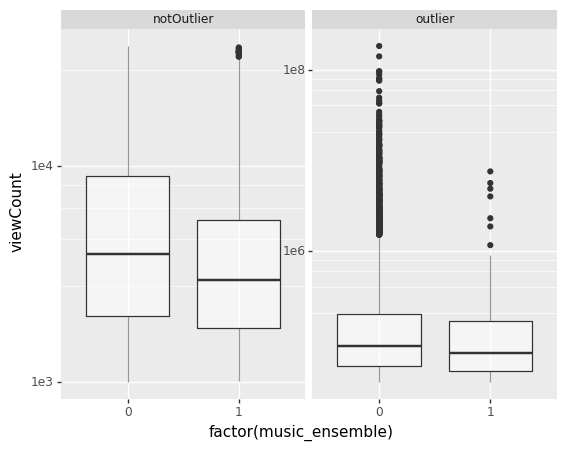

<ggplot: (-9223371939006501772)>

In [34]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(music_ensemble)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

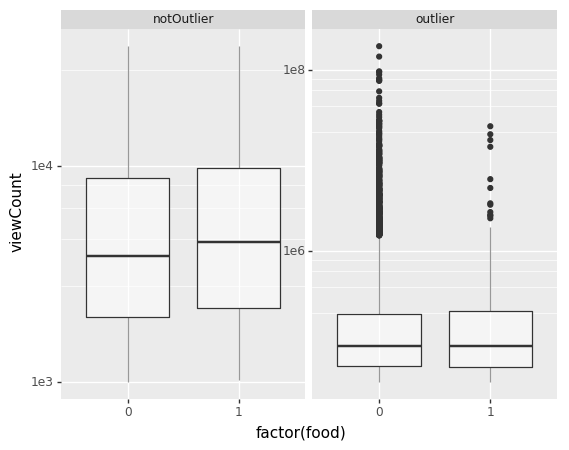

<ggplot: (-9223371939009706997)>

In [30]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(food)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

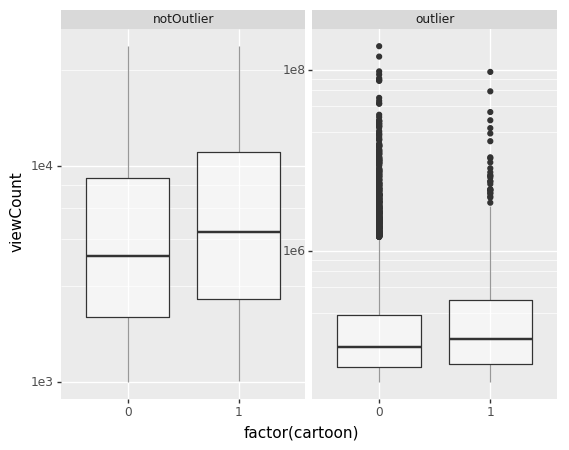

<ggplot: (97845028521)>

In [29]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(cartoon)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

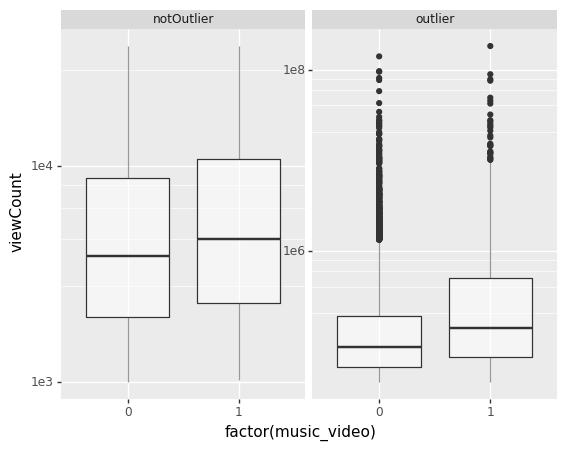

<ggplot: (-9223371938991507554)>

In [25]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(music_video)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

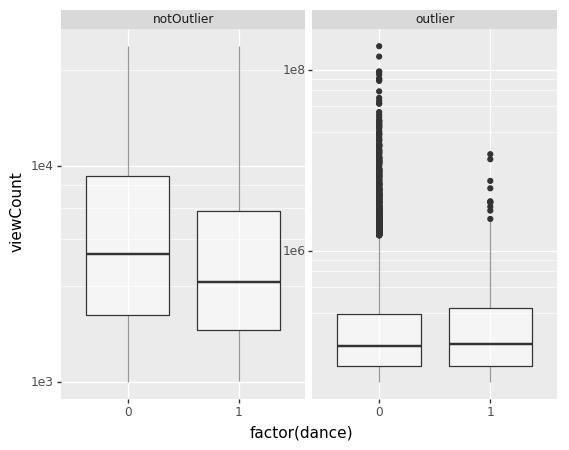

<ggplot: (-9223371938991505113)>

In [24]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(dance)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

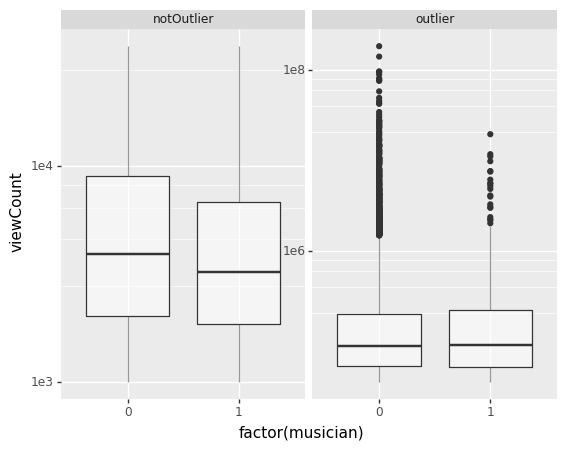

<ggplot: (97883015358)>

In [23]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(musician)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

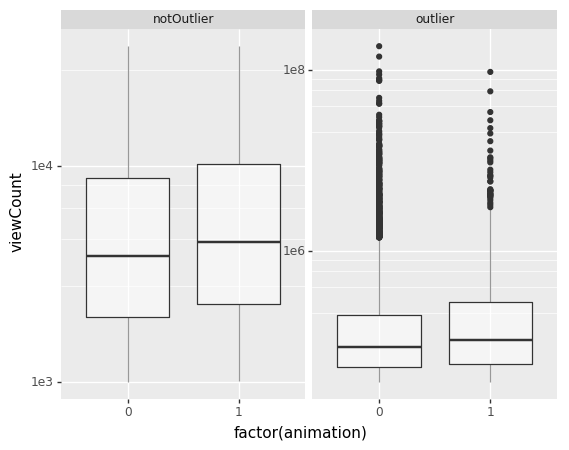

<ggplot: (-9223371938971751564)>

In [22]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(animation)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

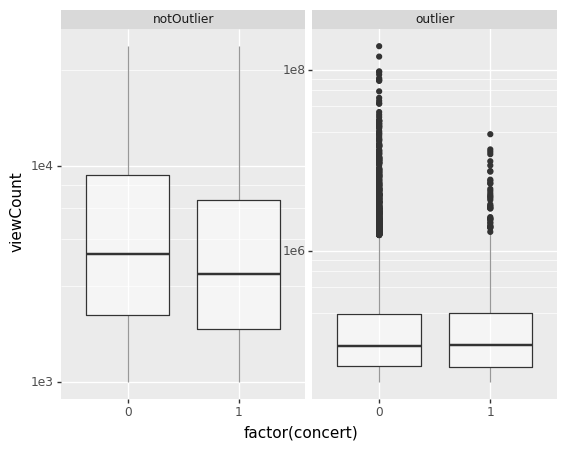

<ggplot: (-9223371938980109105)>

In [18]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(concert)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

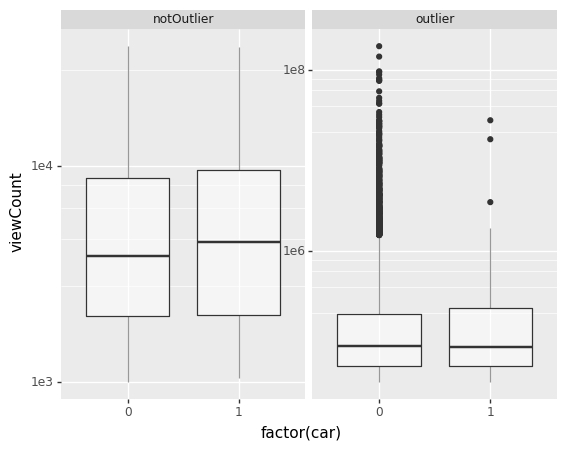

<ggplot: (-9223371938971836770)>

In [19]:
ggplot(youtube_data, aes(y = "viewCount", x = 'factor(car)')) + \
    geom_boxplot(alpha = 0.5) + \
    scale_y_log10() + \
    facet_wrap("outlier", scales="free")

### Feature Reduction

In [80]:
for column1 in youtube_ml:
    for column2 in youtube_ml:
        unwantedCols = set(['viewCount', 'outlier'])
        if column1 not in unwantedCols and column2 not in unwantedCols:
            if column1 != column2:
                if youtube_ml[column1].corr(youtube_ml[column2]) > 0.5:
                    print(column1, column2, youtube_ml[column1].corr(youtube_ml[column2]))

likeCount dislikeCount 0.7190478177692307
likeCount commentCount 0.7972278086091602
dislikeCount likeCount 0.7190478177692307
dislikeCount commentCount 0.6892938646353679
commentCount likeCount 0.7972278086091602
commentCount dislikeCount 0.6892938646353679
music_ensemble musician 0.5708604637279636
animation cartoon 0.603860376171401
cartoon animation 0.603860376171401
musician music_ensemble 0.5708604637279637


We can see there is a high correlation among some of the features. 

## ML Analysis

Now, we will create a new dataframe that only contains the features that we decided to include, so that we can run ML algorithms on it.

In [103]:
import math
youtube_ml = youtube_ml[['titleLen', 'likeCount', 'title_JJ', 'title_CD', 'title_IN', 
                           'car', 'dance', 'concert', 'food', 'cartoon', 'musician', 
                           'music_video', 'viewCount', 'outlier']].copy()
youtube_ml['viewCount'] = youtube_ml['viewCount'].apply(lambda x: math.log(x + 1))
youtube_ml['likeCount'] = youtube_ml['likeCount'].apply(lambda x: math.log(x + 1))
youtube_ml = getWordFreqVectors(youtube_ml, youtube_data['titleWords'])

Now we will split the data into train (70%) and test (30%) sets. We will first try to classify a video into outliers vs. non-outliers. Then, within the non-outliers group, we will try to predict the normalized, log-transformed view count. So in the code below, we split the data for both the classification and regression tasks.

In [104]:
# Separate into data and labels, train vs. test
P = np.random.permutation(len(youtube_ml.index))
labels = youtube_ml['outlier'].apply(lambda x: 1 if x == 'outlier' else 0)
reg_target = youtube_ml['viewCount']
feature_cols = [True if col not in ['viewCount', 'outlier'] else False for col in youtube_ml.columns]
features = youtube_ml.loc[:,  feature_cols]
features = features.fillna(0)
features_nonOut = features[labels == 0].reset_index() # nonOutlier features
regtarget_nonOut = reg_target[labels == 0].reset_index() # nonOutlier viewCounts
split_tr = math.ceil(len(P) * 0.70)
P_nonOut = np.random.permutation(features_nonOut.shape[0])
split_nonOut = math.ceil(len(P_nonOut) * 0.70)

regtarget_nonOut = (regtarget_nonOut - np.mean(regtarget_nonOut)) / np.std(regtarget_nonOut)

tr_features, te_features = features.loc[P[:split_tr]].as_matrix(), features.loc[P[split_tr:]].as_matrix()

tr_labels, te_labels = labels.loc[P[:split_tr]].as_matrix(), labels.loc[P[split_tr:]].as_matrix()
    
tr_reg_target, te_reg_target = reg_target[P[:split_tr]].as_matrix(), reg_target[P[split_tr:]].as_matrix()

tr_features_nonOut, te_features_nonOut = features_nonOut.loc[P_nonOut[:split_nonOut]].as_matrix(), \
                                         features_nonOut.loc[P_nonOut[split_nonOut:]].as_matrix()
    
tr_regtarget_nonOut, te_regtarget_nonOut = regtarget_nonOut.loc[P_nonOut[:split_nonOut]]['viewCount'].values, \
                                           regtarget_nonOut.loc[P_nonOut[split_nonOut:]]['viewCount'].values

#### Baseline

To compare our future ML models, we first create a baseline. For the classification task, we will take the most frequent label in the training set. For the regression task, we will use the mean view count.

In [107]:
#Baseline for classification
numOutliers = (tr_labels == 1).sum()
numNonOutliers = (tr_labels == 0).sum()
mostFrequent = 0
if (numOutliers > numNonOutliers):
    mostFrequent = 1
baseline_classification = (te_labels == mostFrequent).mean()

#Baseline for regression
baseline_regression = np.mean(np.square((te_regtarget_nonOut - np.mean(tr_regtarget_nonOut))))

print(baseline_classification, baseline_regression)

0.8599269624326572 1.0101070059028008


#### Gradient Boosting

We will use GradientBoostingClassifier GradientBoostingRegressor, and compare the results to our baseline.

In [108]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

# GradientBoosting Classifier to differentiate Outliers
outlier_clf = GradientBoostingClassifier()
outlier_clf.fit(tr_features, tr_labels)
#get_err_samples(outlier_clf, tr_features, tr_labels, te_features, te_labels)
gb_c = (te_labels == outlier_clf.predict(te_features)).mean()
print("Accuracy Classification: ", gb_c)

# GradientBoosting Regressor to predict viewcounts on nonOutlier data
views_rgr_nonOut = GradientBoostingRegressor()
views_rgr_nonOut.fit(tr_features_nonOut, tr_regtarget_nonOut)
#get_err_samples(views_rgr_nonOut, tr_features_nonOut, tr_regtarget_nonOut, te_features_nonOut, te_regtarget_nonOut)
error_nonOut = np.mean(np.square(te_regtarget_nonOut - views_rgr_nonOut.predict(te_features_nonOut)))
gb_r = error_nonOut.mean()
print("MSE Regression: ", gb_r)

Accuracy Classification:  0.9157536970748816
MSE Regression:  0.6428831252263834


#### Random Forest

We will use RandomForestClassifier and RandomForestRegressor, and compare the results to our baseline.

For more information about Random Forests: https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd

In [109]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# RandomForest Classifier to differentiate Outliers
outlier_clf = RandomForestClassifier()
outlier_clf.fit(tr_features, tr_labels)
rf_c = (te_labels == outlier_clf.predict(te_features)).mean()
print("Accuracy Classification: ", rf_c)

# RandomForest Regressor to predict viewcounts on nonOutlier data
views_rgr_nonOut = RandomForestRegressor()
views_rgr_nonOut.fit(tr_features_nonOut, tr_regtarget_nonOut)
error_nonOut = np.mean(np.square(te_regtarget_nonOut - views_rgr_nonOut.predict(te_features_nonOut)))
rf_r = error_nonOut.mean()
print("MSE Regression: ", rf_r)

Accuracy Classification:  0.8976027768738475
MSE Regression:  0.7794352299854599


#### MLP 

In [110]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

# MLP Classifier to differentiate Outliers
outlier_clf = MLPClassifier()
outlier_clf.fit(tr_features, tr_labels)
mlp_c = (te_labels == outlier_clf.predict(te_features)).mean()
print("Accuracy Classification: ", mlp_c)

# MLP Regressor to predict viewcounts on nonOutlier data
views_rgr_nonOut = MLPRegressor(learning_rate = "adaptive", solver = "lbfgs", hidden_layer_sizes = (10,10,10,10,10), max_iter = 2000)
views_rgr_nonOut.fit(tr_features_nonOut, tr_regtarget_nonOut)
error_nonOut = np.mean(np.square(te_regtarget_nonOut - views_rgr_nonOut.predict(te_features_nonOut)))
mlp_r = error_nonOut.mean()
print("MSE Regression: ", mlp_r)

error_nonOut = np.mean(np.square(tr_regtarget_nonOut - views_rgr_nonOut.predict(tr_features_nonOut)))
mlp_r = error_nonOut.mean()
print("MSE Regression: ", mlp_r)

Accuracy Classification:  0.9155367538055466
MSE Regression:  1.0367762562558067
MSE Regression:  1.022810599952813


#### Logistic/Linear Regression

In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

# Logistic Regression Classifier to differentiate Outliers
outlier_clf = LogisticRegression()
outlier_clf.fit(tr_features, tr_labels)
rf_c = (te_labels == outlier_clf.predict(te_features)).mean()
print("Accuracy Classification: ", rf_c)

# Linear Regression Regressor to predict viewcounts on nonOutlier data
views_rgr_nonOut = LinearRegression()
views_rgr_nonOut.fit(tr_features_nonOut, tr_regtarget_nonOut)
error_nonOut = np.mean(np.square(te_regtarget_nonOut - views_rgr_nonOut.predict(te_features_nonOut)))
rf_r = error_nonOut.mean()
print("MSE Regression: ", rf_r)

Accuracy Classification:  0.9163322124597751
MSE Regression:  0.6790433955608193


#### Comparison

In [95]:
l1 = ["Baseline", "MLP", "Gradient Boosting", "Random Forest"]
cl = [baseline_classification, mlp_c, gb_c, rf_c]
r = [baseline_regression, mlp_r, gb_r, rf_r]

df = pd.concat([pd.Series(l1), pd.Series(cl), pd.Series(r)], axis = 1)
df.columns = ["Algorithm", "Accuracy_Classification", "MSE_Regression"]
print(df)

           Algorithm  Accuracy_Classification  MSE_Regression
0           Baseline                 0.859855        0.021106
1                MLP                 0.913584        0.986405
2  Gradient Boosting                 0.914344        0.698365
3      Random Forest                 0.896410        0.825313


In [89]:
# Write dataframe to PKL file for future use
youtube_ml.to_pickle("youtube_features.pkl")

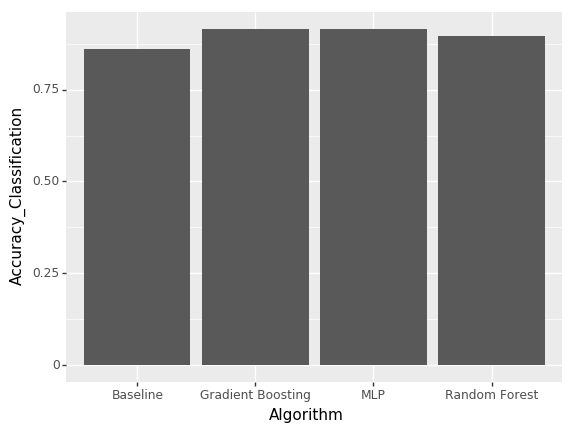

<ggplot: (-9223372036564942062)>

In [96]:
ggplot(aes(x = "Algorithm", y = "Accuracy_Classification"), df) + geom_col()

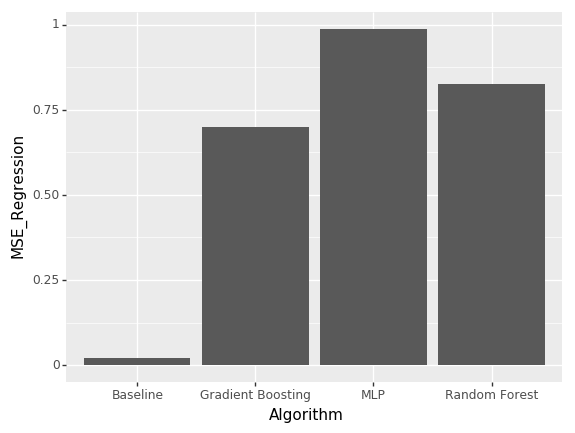

<ggplot: (-9223372036563994922)>

In [97]:
ggplot(aes(x = "Algorithm", y = "MSE_Regression"), df) + geom_col()

Firstly, we note all three of the models do much better than baseline. It seems the best algorithm for both classification accuracy and MSE regression is Gradient Boosting. We see Random Forest and Gradient Boosting both seem to do better than MLP (for regression). This makes sense because these are what are called "ensemble methods" which combine multiple tree models that are fit to random subsets of the data, and that leads to a better predictor. Also decision trees are insensitive to scale of features, and since we only normalized view count this benefits our models. Gradient boosting is preferred it does boosting. In other words, it upweights and downweights points through iterations. Also since our data is tabular boosting works well. 

### Future Plans

### References

https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd
http://scikit-learn.org/stable/modules/ensemble.html
http://scikit-learn.org/stable/modules/neural_networks_supervised.html